# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [8]:
norm_train_X.shape , train_Y[1].shape

((614, 8), (614,))

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [11]:
# Define model layers.
inp = Input(shape=(norm_train_X.shape[1],))
first = Dense(128,activation='relu')(inp)
second = Dense(128,activation='relu')(first)

# Y1 output will be fed directly from the second dense
out1 = Dense(1,name='y1_out')(second)
third = Dense(64,activation='relu')(second)

# Y2 output will come via the third dense
out2 = Dense(1,name='y2_out')(third)

# Define the model with the input layer and a list of output layers
model = Model(inputs=[inp],outputs=[out1,out2])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          1152        input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          16512       dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 64)           8256        dense_7[0][0]                    
____________________________________________________________________________________________

In [17]:
from tensorflow.python.keras.utils.vis_utils import plot_model

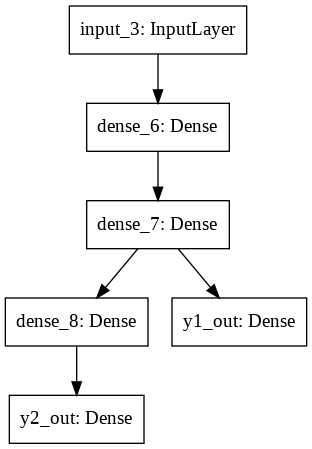

In [18]:
plot_model(model)

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [12]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_out': 'mse', 'y2_out': 'mse'},
              metrics={'y1_out': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_out': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [13]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1ms/sample - loss: 242.7747 - y1_out_loss: 114.1463 - y2_out_loss: 126.3152 - y1_out_root_mean_squared_error: 10.7347 - y2_out_root_mean_squared_error: 11.2934 - val_loss: 33.3242 - val_y1_out_loss: 12.0568 - val_y2_out_loss: 20.3106 - val_y1_out_root_mean_squared_error: 3.5151 - val_y2_out_root_mean_squared_error: 4.5791
Epoch 2/500
614/614 [==============================] - 0s 140us/sample - loss: 31.7653 - y1_out_loss: 12.4458 - y2_out_loss: 19.2863 - y1_out_root_mean_squared_error: 3.5405 - y2_out_root_mean_squared_error: 4.3852 - val_loss: 28.8590 - val_y1_out_loss: 10.0748 - val_y2_out_loss: 18.7618 - val_y1_out_root_mean_squared_error: 3.1980 - val_y2_out_root_mean_squared_error: 4.3164
Epoch 3/500
614/614 [==============================] - 0s 141us/sample - loss: 25.7604 - y1_out_loss: 10.2254 - y2_out_loss: 15.4658 - y1_out_root_mean_squared_error: 3.2036 - y2_out_root_mean_

## Evaluate the Model and Plot Metrics

In [14]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 34us/sample - loss: 0.6791 - y1_out_loss: 0.2376 - y2_out_loss: 0.4270 - y1_out_root_mean_squared_error: 0.4911 - y2_out_root_mean_squared_error: 0.6617
Loss = 0.6790838775696693, Y1_loss = 0.23756945133209229, Y1_mse = 0.49111202359199524, Y2_loss = 0.4270336627960205, Y2_mse = 0.6617347598075867


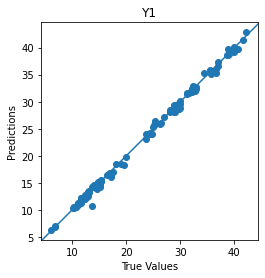

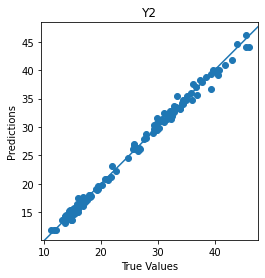

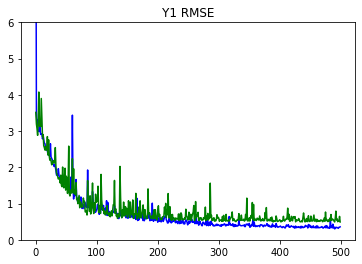

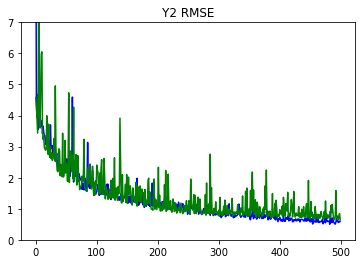

In [16]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_out_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_out_root_mean_squared_error', title='Y2 RMSE', ylim=7)